# Weekly Session 4 - Integrals in Computational Physics

### Goal
To develop a basic familiarity and proficiency with numerical integration.

### Readings
This week, we will cover the most essential subsections on integration in Newman:

    5.1 Fundamental methods for evaluating integrals

    5.2 Errors on integrals

    5.3 Choosing the number of steps

    5.5 Higher-order integration methods

    5.7 Choosing an integration method 

## Overview

You will build up your own module named ```integration```, containing
functions which implement the two basic numerical integration
methods based on equally-spaced mesh points: 
the *trapezoidal rule* and *Simpson's rule*.  

You will explore the accuracy of these routines numerically, try out
error estimation, and see how they can serve as the basis for adaptive
routines.

For lab we will practice using them on interesting integrals in physics.

In [1]:
#For colored cells, currently black cells, white text is added in Markdown
#https://stackoverflow.com/questions/18024769/adding-custom-styled-paragraphs-in-markdown-cells
from IPython.core.display import HTML
def css_styling():
    styles = open("style.css", "r").read()
    return HTML(styles)
css_styling()

<div class=answer>
*This should be a blue cell with black font if you set the filepath correctly*</font>
<div/>

## Exercise 0: floating point numbers to single precision
#### *A review on round-off error*

Python automatically uses double precision of all floating point numbers.  While this is typically a good thing - the rounding errors are minimized this way - many other languages such as C and C++ have distinct types of floating point numbers - single precision (32 bytes) and double precision (64 bytes) - that use different amounts of memory.  For testing our numerical solutions of integrals, it will be useful to examine single precision floats (```np.float32()```) and compare them to double precision floats (python's default ```float()```, which can be specified with ```np.float64()```).  Here is a basic example comparing the default to the single precision float: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.e              #numpy's value for Euler's number -e 
print(x)              #print e with 64 bits of memory, or 16 digits 
print(np.float32(x))  #print e with 32 bits of memory, or 5 digits

2.718281828459045
2.71828


Here is another example where I examine the round-off error with a complex number e^{i*pi}

In [3]:
x = np.e                  #numpy's value for Euler's number -e 
y = complex(0.0,np.pi)    #a complex number y = i pi

a_exact = -1.0
a32 = np.float32(x)**(y) #note that only x is a 32 bit number, y is 64 bit
a64 = x**y

error32 = abs(a32-a_exact)  #divided by a_exact = 1
error64 = abs(a64-a_exact)  #divided by a_exact = 1

print("The exact result for e^{i pi} = ", a_exact)
print("The 32-byte floating point result is ", a32)
print("The 64-byte floating point result is ", a64)

print("The relative roundoff error for the float32 value is: ",error32)
print("The relative roundoff error for the float64 value is: ",error64)

The exact result for e^{i pi} =  -1.0
The 32-byte floating point result is  (-1+9.54034461546e-08j)
The 64-byte floating point result is  (-1+1.2246467991473532e-16j)
The relative roundoff error for the float32 value is:  9.54034461546e-08
The relative roundoff error for the float64 value is:  1.2246467991473532e-16


<div class=answer>
 __Write a code to examine the float32 and float64 values of the following function:
$$
f(x) = \frac{1}{\sqrt{x}}
$$
where $x~ =~ 1,~10^2,~10^4,~10^6$.  Compare the numerical values to the exact results as in the example above.__
    
Please use a loop to speed up your work!
<div/>

In [4]:
import math

def f(x):
    value = 1/math.sqrt(x)
    return value

a_exact = [1, 0.1, 0.01, 0.001]
r = [1, 10**2, 10**4, 10**6]
counter = 0

for x in r:
    a32 = np.float32(f(x))
    a64 = f(x)
    
    exactV = a_exact[counter]
    
    counter += 1
    
    error32 = abs(a32-exactV)
    error64 = abs(a64-exactV)
    
    print("The exact result for f(x) = ", exactV)
    print("The 32-byte floating point result is ", a32)
    print("The 64-byte floating point result is ", a64)

    print("The relative roundoff error for the float32 value is: ",error32)
    print("The relative roundoff error for the float64 value is: ",error64)
      

The exact result for f(x) =  1
The 32-byte floating point result is  1.0
The 64-byte floating point result is  1.0
The relative roundoff error for the float32 value is:  0.0
The relative roundoff error for the float64 value is:  0.0
The exact result for f(x) =  0.1
The 32-byte floating point result is  0.1
The 64-byte floating point result is  0.1
The relative roundoff error for the float32 value is:  1.49011611383e-09
The relative roundoff error for the float64 value is:  0.0
The exact result for f(x) =  0.01
The 32-byte floating point result is  0.01
The 64-byte floating point result is  0.01
The relative roundoff error for the float32 value is:  2.23517418116e-10
The relative roundoff error for the float64 value is:  0.0
The exact result for f(x) =  0.001
The 32-byte floating point result is  0.001
The 64-byte floating point result is  0.001
The relative roundoff error for the float32 value is:  4.74974512846e-11
The relative roundoff error for the float64 value is:  0.0


## Exercise 1: General form of Integrals

As Newman points out -- if you look ahead to Section 5.5 on page 163 --
the trapezoidal rule and Simpson's rule both have the same general form

$$
\int_a^bf(x)\,dx \approx \sum_{k=0}^N w_k f(x_k),
$$

where the $x_k$ are equally spaced points, with 
$$
x_k=a+k\frac{(b-a)}{N}.
$$

The only difference is in the different choices for $w_k$.  These two
methods are actually the first two special cases of the more general
Newton-Cotes formulas, which is based on local polynomial approximations to the
function: the linear approximation gives the trapezoidal rule, the quadratic
approximation gives Simpson's rule, *etc.*  In fact, take a
look at the nice table on page 164 to see this similarity.

Actually, though, if you try to use Newman's (5.52) and the table of
weights on page 164 to actually do a calculation, you will soon
discover that there is a very important factor missing!  
__ Compare (5.52) to the trapezoidal and Simpson's formulas.  What factor is missing? __ 

<div class=answer>
Answer here: They forgot the h when they made the table.
<div/>
__P.S.__ I only noticed this the hard way as I was coding it up myself.

### Test case

For initial testing of our integration functions, we will use the integral
\begin{equation}
\label{eqn-int-exp}
\int_0^1 e^{-x}\,dx.
\end{equation}
The integrand varies smoothly, so this is an "easy" case.  Also, the
result is known analytically, so we can easily check our answer's precision.

__In fact, what *is* the correct answer, analytically?  And what is this as a floating point number, to as many places as you can write in double precision?__

In [5]:
-np.e**(-1)+1

0.6321205588285577

<div class=answer>
Answer here: The correct answer analytically is in the cell above.  
<div/>

## Basic integration of functions

We are about to write two functions: one to evaluate a definite integral by
the trapezoidal rule (```trapezoidal()```) and one to evaluate a
definite integral by Simpson's rule (```simpson()```).
You are welcome to reuse your code for Example 5.1, 
but now use a more general approach appropriate for calling a 
trapezoid integral later in the notebook.

First you will need to design an "interface" 
-- *i.e.* select the input parameters and return value --
for each of these functions.  Is there any difference between the interface for these
two functions?

__What will be your interface?__  see the hints/notes below.  

__Hint:__ Is there any constraint on the number of steps for the
trapezoidal rule?  How about Simpson's rule?

__Note:__
For reasons of sanity, please make sure your function takes as a
parameter the number of *steps* $N$ for the integration, not the
number of *points* for the integration.  

<div class=answer>
Answer here: The constraint is that N must be even in the case of Simpson's rule.  The interfaces for both will have N, a, b and s?  
<div/>

__ Now write these two functions, and test them out the benchmark integral given in the test integral__.

__Hint:__ Newman break's Simpson's rule up into two sums in (5.9).  Ugly!
Can you do this as one sum, calculating the correct weight $w_k$ for
each term, like in (5.52), as discussed above?  Do you see
any way you can use the
```%``` operator to make your life simpler?  

In [21]:
-np.e**(-1)+1

def trapezoid(N, a, b, f, h):
    
    s = (0.5*f(a) + 0.5*f(b)) 
    for i in range(1,N):
        s+= f(a+i*h)         
    
    return(h*s)     
  
    
def simpson(N, a, b, f, h):
         
    s = f(a) + f(b)
    c = 0
    
    if N%2 != 0:
        return("Fail")
    else:
        for k in range(1,N):
             if k%2 == 0:
                 s += f(a+k*h)

             elif k%2 == 1:
                 c += f(a+k*h)

        s = 2*s + 4*c
        return(h/3*s)
         
         
N = 10000                      
a = 0.0                     
b = 1.0                     
h = (b-a)/N 
    
print(-np.e**(-1)+1)    
print(simpson(N,a,b,f,h))
print(trapezoid(N,a,b,f,h))

0.6321205588285577
0.6321661548099312
0.6321205593553268


## Exercise 2: An interlude
### Plotting log-log plots and the np.logspace() function

In Exercise 3 you will make log-log plots to examine the error in your numerical solutions of integrals.  Log-log plots are a highly useful manner to examine non-linear trends in data.  Here is an example to practice working with them outside of the integration.  

Note that ```pylab``` can plot on log-log axes automatically with the function ```pylab.loglog```.  See
https://matplotlib.org/examples/pylab_examples/log_demo.html 
if you would like to explore more.

Lets start by making a very sparse set of points for your $x$-axis, with integer exponents,
like $10^1$, $10^2$, $10^3$, with the numpy array generating function ```logspace()``` (which is very similar to ```linspace()```)

In [ ]:
#source: https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html

N = 10
x1 = np.logspace(1, 2, N, endpoint=True)    #where 1 means 10^1 and 2 means 10^2
x2 = np.logspace(1, 2, N, endpoint=False)
y = np.zeros(N)
plt.plot(x1, y, 'o', label="endpoint=True")
plt.plot(x2, y + 0.5, 'o',label='endpoint=False')
plt.ylim([-0.5, 1])
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

__ Play with the np.logspace() function below.  Make an array of ten integers that spans from 1-1000 and present your results on a plot similar to that above.  Next make an array of ten EVEN integers that spans from 1-1024 and add it to your plot__ 

__Hint:__ play with the optional argument ```base``` documented here:
https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html

and illustrated here:
https://matplotlib.org/examples/pylab_examples/log_demo.html

My array of even numbers were as follows, what is the base?
[   2    4    8   16   32   64  128  256  512 1024]

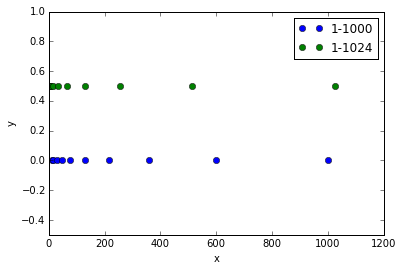

[   10.            16.68100537    27.82559402    46.41588834    77.42636827
   129.1549665    215.443469     359.38136638   599.48425032  1000.        ]
[    2.     4.     8.    16.    32.    64.   128.   256.   512.  1024.]


In [20]:
x3 = np.logspace(1, 3, 10, endpoint=True)
x4 = np.logspace(1, 10, 10, base=2, endpoint=True)

y = np.zeros(N)
plt.plot(x3, y, 'o', label="1-1000")
plt.plot(x4, y + 0.5, 'o',label='1-1024')
plt.ylim([-0.5, 1])
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

print(x3)
print(x4)

### LogLog plots
Now lets make some interesting y-data, plot $y ~vs.~ x$, and compare the results for a linear-linear, log-linear, and log-log plot.  I have provided a full example below.  Use this as an example to do the plot in Exercise 3 when you get there. 
*Don't miss the question that follows the plots!*

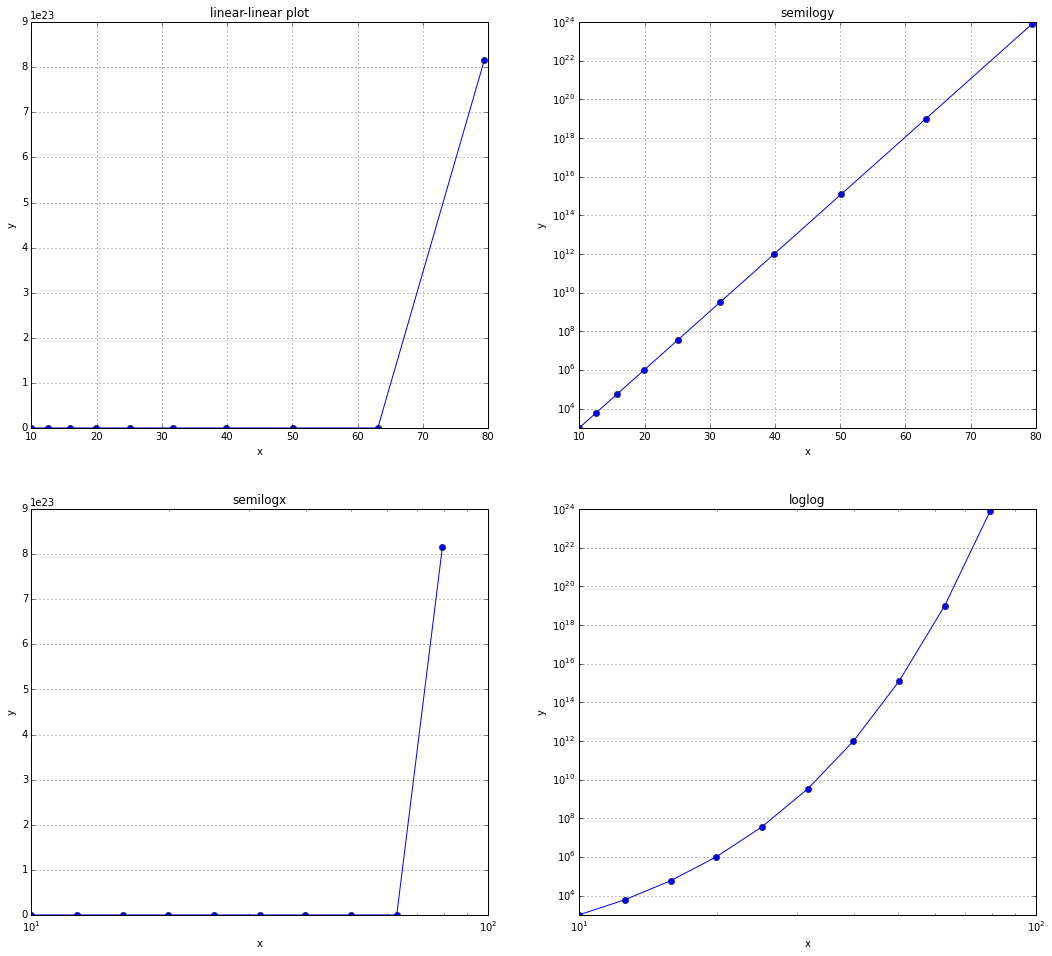

In [8]:
# log x and y axis
# Example of log style plots
# source: https://matplotlib.org/examples/pylab_examples/log_demo.html

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

N = 10
x1 = np.logspace(1, 2, N, endpoint=False)
y1 = 2**x1 

# log y axis
plt.subplot(221)
plt.plot(x1, y1,'o-')
plt.title('linear-linear plot')
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")

# log y axis
plt.subplot(222)
plt.semilogy(x1, y1,'o-')
plt.title('semilogy')
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
             
# log x axis
plt.subplot(223)
plt.semilogx(x1, y1,'o-')
plt.title('semilogx')
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
             
# log x and y axis
plt.subplot(224)
plt.loglog(x1, y1,'o-')
plt.grid(True)
plt.title('loglog')
plt.xlabel("x")
plt.ylabel("y")

plt.show()

<div class=answer>
 __ Now that you've seen the example, why do you think log-log plots are so useful?  Can you think of another example in your physics (or math, CS, etc) background where log-log plots were useful?  Discuss with your partner and explain. __
<div/>

Log scales are so useful because they make it possible to see all the data points, and what is going on with them.  The two plots with log based y axis show the behavior of the x data points, where as the plots without the log base y axis do not show the behavior of the points in any useful way what so ever.

## Exercise 3
### Algorithmic and roundoff error 

Make a log-log plot of the __error__ in the calculation of the benchmark
integral *vs.* the number of steps, for both the trapezoidal rule and
Simpson's rule.  
Here the benchmark integral is the numerical algorithm which you may compare to the exact result.

The goal is to see if the behavior of the errors follows the pattern
we expect from Newman's discussion.  That is, we expect
*approximation error* (or *algorithmic error*) to dominate
for small $N$, and *roundoff error* to dominate for large $N$.  


For the trapezoidal rule, it will be very hard for you to reach the regime
in which roundoff error dominates, since the algorithmic error is just
so overwhelmingly bad, and double precision arithmetic is just so
wonderfully good.  Thus, for us to have a chance to see the onset of
roundoff error more easily, it would be nice if your functions could also work in single precision.
Modify your functions so that they take an
*optional* argument ```float_type=np.float32``` 
and convert each term in the sum to this float type before adding it to the sum. 

__Hint:__  Make log-log plots showing the errors for the two methods
*vs.* number of steps (so ```simpson()``` and ```trapezoid()``` are on the same panel), in 
both single and double precision (do a separate panel for float32/single and float64/doubles).  
*Use the results from Exercises 0 and 2.*


__Hint:__ Chose a set of closely-spaced points for your $x$-axis ($N$-values).  My base-2 even integers from Exercise 2 are a great starting point.

Of course, in the end, you need to pick integer values for the number of steps.  But that's what
rounding is for, isn't it?  You might need to use some arithmetic creativity to
make sure the number of points is even for Simpson's rule.  There isn't a right way to achieve this, you can do it by hand or with some simple math tricks.

__Enter your code in the cells below (add more if you like).  Make log-log plots showing the errors for the two methods *vs.* number of steps (overlaid on top of each other), in both single and double precision.  As always label your plots well.__

[0.083310330812411057, 0.0033421879714381343, 0.00083776165098124928, 0.00013290142391846071, 5.5656467530183497e-05, 2.6689608895556701e-05, 0.00017731727384479376, 4.6693099682966574e-05]
[7.213233536780872, 1.4426327255105054, 0.72132029081615823, 0.28852443162210922, 0.14426130348976143, 0.072138056080262442, 0.014405630795963098, 0.0072736815442900381]


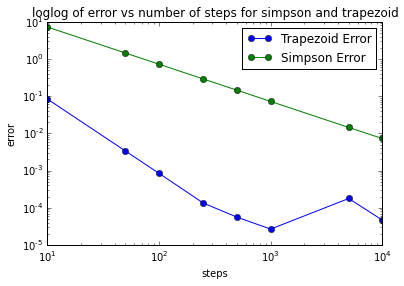

In [25]:
def error(approx, analytic):
    return(((abs(approx-analytic))/analytic)*100)

def f(x):
    value = math.e**-x
    return value

def trapezoid(N, a, b, f, float_type=np.float32):
    h = (b-a)/N  
    s = float_type((0.5*f(a) + 0.5*f(b))) 
    for i in range(1,N):
        s+= float_type(f(a+i*h))         
    
    return(h*s)     
  
    
def simpson(N, a, b, f, float_type=np.float32):
    
    h = (b-a)/N  
    s = float_type(f(a) + f(b))
    c = 0
    
    if N%2 != 0:
        return("Fail")
    else:
        for k in range(1,N):
             if k%2 == 0:
                 s += float_type(f(a+k*h))

             elif k%2 == 1:
                 c += float_type(f(a+k*h))

        s = 2*s + 4*c
        return(h/3*s) 
    
  
    
analytic = -np.e**(-1)+1

N_array = [10,50,100,250,500,1000,5000,10000]
error_array = []
error_array2 = []
a = 0.0                     
b = 1.0                     

for n in N_array:
    approx = trapezoid(n,a,b,f)
    error_array.append(error(approx,analytic))
print(error_array)

for i in N_array:
    approx2 = simpson(i,a,b,f)
    error_array2.append(error(approx2,analytic))
print(error_array2)

    
plt.loglog(N_array, error_array,'bo-',label="Trapezoid Error")
plt.loglog(N_array,error_array2, 'go-',label="Simpson Error")
plt.title('loglog of error vs number of steps for simpson and trapezoid')
plt.xlabel("steps")
plt.ylabel("error")
plt.legend()

<div class=answer>
__ For each method, identify the region in which algorithmic error dominates and the region in which roundoff error dominates.  For the algorithmic error, try to read the exponent off from the slope of the plot and compare with the expected value from Newman's analysis.  Where do you expect the "crossover" between these regions to occur
from Newman's estimates, given single or double precision?  Is this consistent with what you observe?__
<div/>
Answer here

## Exercise 4:
### Error estimation 

In Section 5.2.1, Newman describes the practical method for estimating the error in a trapezoidal rule or Simpson's rule calculation.  Try these error estimates out for the trapezoidal rule, with $20$ steps
and $200$ steps.  __How close are the estimates to the actual errors?__  What about the sign (this will matter when we get to Romberg integration)? Repeat for Simpson's rule.


In [ ]:
#enter your code here

<div class=answer>
<div/>
Answer here

## Exercise 5: 
### Programming technique: Generalizing a function

If you are thinking like a computer scientist, you are probably just
starting to get a little irked by now.  

You just did a bit of cutting and pasting, didn't you?  You started
from the function ```trapezoidal()``` and adapted it to write the function ```simpson()```, right?  
These functions both share the same interface, and the code for each of them is nearly the
same, *i.e.*, they both compute a sum
$$
\sum_{k=0}^N w_k f(x_k),
$$
with the same values of $x_k$, but just some slight differences in the
values you use for the coefficients $w_k$.  

Then, when you needed to make an addition to these functions (adding
the parameter ```float_type```, you had to go back and make the 
*exact same modifications* to your code *twice*, once in each the functions.   

Wasn't that annoying?  More precisely, wasn't that a waste of effort?
And doesn't this duplication serve as a big deterrent against your making other such
modifications and improvements in the future?  Imagine if you had gone even further, and written
separate functions for each of the higher-order Newton-Cotes integration rules
(Newman Section 5.5)?  Then you would have had to go back and modify all four functions!

A much more farsighted approach would be to *generalize* your
original *trapezoidal* function, instead of
simply *cutting and pasting* it to make new functions.

#### It's still not too late!

Even if your first attempt is based on cutting and pasting, you can
later recognize the similarity of
different functions and merge them back together into one function.
When you *recognize redundancy*, you *go back and destroy it*.  A little effort
doing this now saves you from much greater duplicated effort testing, debugging,
and maintaining redundant code in the future.  
(Plus it is so rewarding if you are a neatness freak...)

You will often notice that the functions you find in libraries 
(like ```numpy``` or ```matplotlib```) bundle several related algorithms
into one function, and the user chooses the particular algorithm 
through a ```mode``` parameter.  So, following this model, let us replace your separate integration
functions with one combined function ```integrate```.  
This function should take an optional parameter ```order=1```,
which controls whether to use the weights $w_i$
appropriate to the trapezoidal rule
(first order) or Simpson's rule (second order).  While you are at it,
make your function capable of cubic and quartic integration as
well (see the table in Newman Section~5.5).

__Hint:__   Can you see any way to make use of the following definitions
```python
endpoint_weights = [1/2,1/3,3/8,14/45]
interior_weights = [
    [1],
    [2/3,4/3],
    [3/4,9/8,9/8],
    [28/45,64/45,8/15,64/45]
    ]
```
to make your formula for $w_k$ in the code very simple?


__Go back and add the fourth-order Newton-Cotes method to your log-log error plots. Note that you need steps that are a multiple of 4 for this method.__